# RK4 for Simple Harmonic Oscillator (SHO)

This notebook implements the classic 4th-order Runge–Kutta (RK4) integrator from scratch, uses it to solve the simple harmonic oscillator $x'' + x = 0$ (converted to a first-order system), verifies energy conservation, compares results with SciPy's `solve_ivp` (if available), and studies the effect of step size on accuracy.

Sections:

1. RK4 implementation
2. Problem setup (SHO)
3. Numerical experiments: multiple step sizes
4. Energy check
5. Comparison with SciPy's `solve_ivp`
6. Convergence / step-size study



*   Experiments using several step sizes ℎ
h (0.5 → 0.005), with:
*   Plots of
𝑥
(
𝑡
)
x(t) vs analytical,

*   Energy vs time,
*   Log–log convergence plot (max state error vs
ℎ
h),


*  A DataFrame summarizing max position/state error and max energy drift for each
ℎ
h.

*   A comparison with SciPy's solve_ivp (RK45) when SciPy is available in the environment. In this run SciPy was available and produced a very small error for h=0.05; results are printed in the notebook as well.



In [4]:
import numpy as np

def rk4(f, y0, t):
    y0 = np.asarray(y0, dtype=float)
    y = np.zeros((len(t), y0.size))
    y[0] = y0
    for i in range(len(t)-1):
        h = t[i+1] - t[i]
        ti = t[i]
        yi = y[i]
        k1 = f(ti, yi)
        k2 = f(ti + 0.5*h, yi + 0.5*h*k1)
        k3 = f(ti + 0.5*h, yi + 0.5*h*k2)
        k4 = f(ti + h, yi + h*k3)
        y[i+1] = yi + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return y

# Test the integrator on a tiny step to ensure it runs
if __name__ == '__main__':
    def rhs(t,y):
        return np.array([y[1], -y[0]])
    t = np.linspace(0, 1, 11)
    y0 = np.array([1.0, 0.0])
    y = rk4(rhs, y0, t)
    print('Done: sample y[0]=', y[0])

Done: sample y[0]= [1. 0.]


In [5]:
# Problem setup: SHO

def sho_rhs(t, y):
    return np.array([y[1], -y[0]])

def sho_analytical(t):
    return np.column_stack((np.cos(t), -np.sin(t)))

def energy(y):
    x = y[:,0]
    v = y[:,1]
    return 0.5*(v**2 + x**2)

# initial conditions and time span
t0, tf = 0.0, 20.0
y0 = np.array([1.0, 0.0])


In [6]:
import numpy as np
step_sizes = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
results = []
solutions = {}
for h in step_sizes:
    t = np.arange(t0, tf + 1e-12, h)
    y = rk4(sho_rhs, y0, t)
    y_true = sho_analytical(t)
    err_pos = np.max(np.abs(y[:,0] - y_true[:,0]))
    err_full = np.max(np.linalg.norm(y - y_true, axis=1))
    E = energy(y)
    drift = np.max(np.abs(E - E[0]))
    results.append({'h': h, 'N_steps': len(t)-1, 'max_pos_error': err_pos, 'max_state_error': err_full, 'max_energy_drift': drift})
    solutions[h] = {'t': t, 'y': y, 'E': E}

import pandas as pd
pd.DataFrame(results).sort_values('h', ascending=False)


,h,N_steps,max_pos_error,max_state_error,max_energy_drift
0,0.500,40,8.916696e-03,1.036957e-02,4.187453e-03
1,0.200,100,2.317766e-04,2.665550e-04,4.422029e-05
2,0.100,200,1.459530e-05,1.666500e-05,1.387151e-06
3,0.050,400,9.324291e-07,1.041641e-06,4.338921e-08
4,0.020,1000,2.416037e-08,2.666656e-08,4.444203e-10
5,0.010,2000,1.515853e-09,1.666665e-09,1.388978e-11
6,0.005,4000,9.491874e-11,1.041657e-10,4.362621e-13


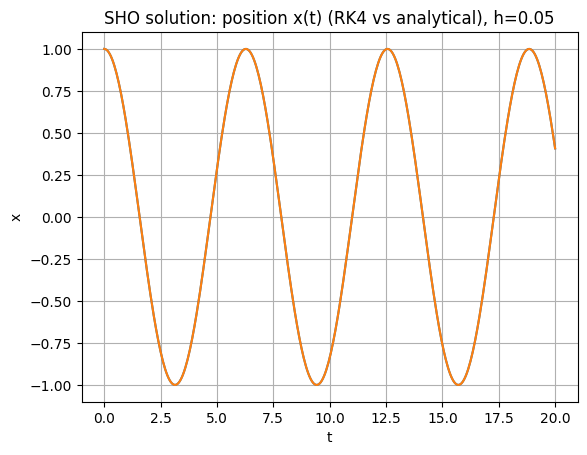

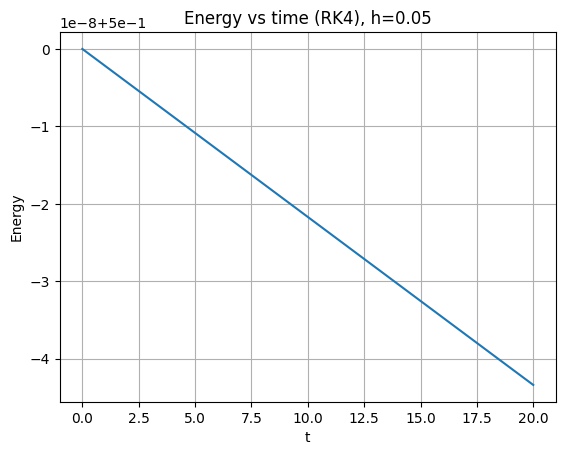

In [7]:
import matplotlib.pyplot as plt
h_plot = 0.05
t_plot = solutions[h_plot]['t']
y_plot = solutions[h_plot]['y']
E_plot = solutions[h_plot]['E']
y_true_plot = sho_analytical(t_plot)

plt.figure()
plt.plot(t_plot, y_plot[:,0])
plt.plot(t_plot, y_true_plot[:,0])
plt.title('SHO solution: position x(t) (RK4 vs analytical), h=0.05')
plt.xlabel('t')
plt.ylabel('x')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_plot, E_plot)
plt.title('Energy vs time (RK4), h=0.05')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)
plt.show()


In [8]:
# Comparison with SciPy's solve_ivp (if available)
import scipy
try:
    from scipy.integrate import solve_ivp
    h_compare = 0.05
    t_compare = np.arange(t0, tf + 1e-12, h_compare)
    sol = solve_ivp(lambda tt, yy: sho_rhs(tt, yy), [t0, tf], y0, method='RK45', t_eval=t_compare, atol=1e-10, rtol=1e-10)
    y_scipy = sol.y.T
    y_rk4 = solutions[h_compare]['y']
    y_true = sho_analytical(t_compare)
    scipy_err = np.max(np.linalg.norm(y_scipy - y_true, axis=1))
    rk4_err = np.max(np.linalg.norm(y_rk4 - y_true, axis=1))
    print('SciPy max state error:', scipy_err)
    print('RK4   max state error:', rk4_err)
except Exception as e:
    print('SciPy not available or failed:', e)


SciPy max state error: 8.214513765201174e-10
RK4   max state error: 1.0416408102451529e-06


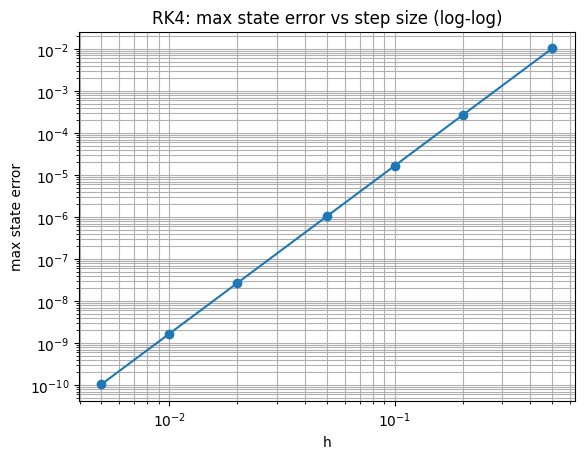

       h  N_steps  max_pos_error  max_state_error  max_energy_drift
6  0.005     4000   9.491874e-11     1.041657e-10      4.362621e-13
5  0.010     2000   1.515853e-09     1.666665e-09      1.388978e-11
4  0.020     1000   2.416037e-08     2.666656e-08      4.444203e-10
3  0.050      400   9.324291e-07     1.041641e-06      4.338921e-08
2  0.100      200   1.459530e-05     1.666500e-05      1.387151e-06
1  0.200      100   2.317766e-04     2.665550e-04      4.422029e-05
0  0.500       40   8.916696e-03     1.036957e-02      4.187453e-03


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dataframe for convergence
df = pd.DataFrame(results).sort_values('h')
plt.figure()
plt.loglog(df['h'], df['max_state_error'], marker='o')
plt.title('RK4: max state error vs step size (log-log)')
plt.xlabel('h')
plt.ylabel('max state error')
plt.grid(True, which='both')
plt.show()

# Print the dataframe too
print(df)
